In [1]:
# Importing the libraries: 
import os
import numpy as np              # Version used: 1.23.1
import glob
import monai                    # Version used: 1.3.0
from monai.transforms import * 
import SimpleITK as sitk        # Version used: 2.3.1
import torch                    # Version used: 1.13.1+cu116
from tqdm import tqdm
import matplotlib.pyplot as plt # Version used: 3.7.5

## Loading the data

In [2]:
# A function 'build_dicts' is made to obtain the filenames from the given dataset.
def build_dicts(data_path='database', mode="training"):

    # Check if the mode is training or testing:
    if mode not in ["training", "testing"]:
        raise ValueError(f"Please choose a mode in ['training', 'testing']. Current mode is {mode}.")

    # Finding the .nii.gz files in the dataset matching the folder and directory names with the variability of patientnumbers and frames. 
    paths_xray = glob.glob(os.path.join(data_path, mode, 'patient*', 'patient*_frame[0-9][0-9].nii.gz'))

    dicts = []
    # Iterate over each file path and extract the ground truth files from the scan file. 
    for scan_file in paths_xray:
        extension_index = scan_file.index(".")
        gt_file = scan_file[:extension_index] + "_gt" + scan_file[extension_index:]

        directory = scan_file.split(os.sep)[:-1]
        cfg_file = os.path.join(*directory, "Info.cfg")

        # Open the info.cfg files to extraxt the disease information for completeness.
        with open(cfg_file, "r") as f:
            line = f.readlines()[2]
            disease = line.split(": ")[1]

        # Make a dictionary with a scan file path, the ground truth file path, and the disease
        if os.path.exists(gt_file):
            dicts.append({"scan_file": scan_file, 
                          "gt_file": gt_file, 
                          "class": disease})
    return dicts

In [3]:
# A function 'ReadFiles' is made to read out scan files from a specific dictionary using SimpleITK.
class ReadFiles(monai.transforms.Transform):
    def __call__(self, sample):
        
        # Disable warnings
        sitk.ProcessObject_SetGlobalWarningDisplay(False)
        
        # Read out the scan file without the ground truth
        image = sitk.ReadImage(sample["scan_file"])

        # Read out the scan file with the ground truth
        mask = sitk.ReadImage(sample["gt_file"])
        
        # Re-able warnings
        sitk.ProcessObject_SetGlobalWarningDisplay(True)

        # Returning a dictionary contain all the relevant information
        return {"img": image,                      # Object of the scan file without the segmenation
                "mask": mask,                      # Object of the mask of the ground truth segmentation
                "img_size": image.GetSize(),       # Size of each scan file
                "img_spacing": image.GetSpacing(), # Spacing of the voxels of each scan file
                "class": sample["class"],          # The disease label of each scan file
                "scan_file": sample["scan_file"]   # Path to the scan file
               }

In [4]:
# A function 'resample_img' is made to set the spacing of the SITK image
def resample_img(itk_image, out_spacing, is_label):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    # Calculate the output size, after the image has been respaced
    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())

    if is_label: 
        resample.SetInterpolator(sitk.sitkNearestNeighbor) # Use nearest neighbour for labels
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [5]:
# A function 'EqualizeSpacing' is made to apply the equalization of the spacings to the images and the masks.
class EqualizeSpacing(monai.transforms.Transform):
    def __call__(self, sample):
        # The original size and spacings of the images and masks are stored in the sample dictionary.
        # This is done so the image can be transformed back after inference
        sample['org_size'] = sample['img_size']
        sample['org_spacing'] = sample['img_spacing']

        # Here all dimensions are equally spaced to 1.25
        image = resample_img(sample['img'], [1.25, 1.25, 1.25], False)
        sample['img'] = image
        sample['img_size'] = image.GetSize()
        sample['img_spacing'] = image.GetSpacing()

        # We do not resample the mask, as we will resample the image back before calculating the metrics
        return sample

In [6]:
# A function 'LoadData' is made to convert the SimpleITK objects to NumPy arrays.
class LoadData(monai.transforms.Transform):
    def __call__(self, sample):
        # Converting the SimpleITK objects to NumPy arrays for the images and the masks.
        sample['img'] = sitk.GetArrayFromImage(sample['img'])
        sample['mask'] = sitk.GetArrayFromImage(sample['mask'])
        
        return sample

In [7]:
# Select GPU if available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [8]:
data_path = 'database'
test_dict_list = build_dicts(data_path, mode='testing')
test_transform = monai.transforms.Compose([
    ReadFiles(),
    EqualizeSpacing(),
    LoadData(),
    EnsureChannelFirstd(channel_dim="no_channel", keys=["img", "mask"]),
    ScaleIntensityd(keys=["img"]),
])

In [9]:
# Applying the composed transform function to the train and validation data sets.
test_set = monai.data.CacheDataset(test_dict_list, transform=test_transform)

Loading dataset: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


In [10]:
# Defining the testing loader.
test_loader = monai.data.DataLoader(test_set, batch_size=1, shuffle=False)

## Loading the models

In [11]:
inferer_3d = monai.inferers.SlidingWindowInferer(roi_size=(32, 176, 176))
inferer_2d = monai.inferers.SliceInferer(roi_size=(176, 176))
softmax = torch.nn.Softmax(dim=1)
output_transform = monai.transforms.Compose([
    AsDiscrete(argmax=True),
    KeepLargestConnectedComponent(applied_labels=[1,2,3],is_onehot=False)
])
score = monai.metrics.DiceMetric(include_background=False)

In [12]:
# A 3D U-net is created with the MONAI library
model_3d = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=4,
    channels=(48, 96, 192, 384, 768),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout=0.25
).to(device)
model_3d.eval()
# Load the pre-trained 3D model.
model_3d.load_state_dict(torch.load('models/trainedUNet3D_final.pt'))

<All keys matched successfully>

In [13]:
# A 3D U-net is created with the MONAI library
model_2d = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=4,
    channels=(48, 96, 192, 384, 768),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout=0.5
).to(device)
model_2d.eval()
# Load the pre-trained 2D model.
model_2d.load_state_dict(torch.load('models/trainedUNet2D_final.pt'))

<All keys matched successfully>

In [14]:
# Creating the metrics
scorer = monai.metrics.DiceMetric(include_background=False)
to_onehot = AsDiscrete(to_onehot=4)

## Calculating the metrics

In [15]:
# Define matrices to store the results, with 3 columns for the 3 classes
scores_3d = np.zeros((len(test_loader), 3))
scores_2d = np.zeros((len(test_loader), 3))
scores_combo = np.zeros((len(test_loader), 3))

# Loop over every sample individually
for (i, sample) in tqdm(enumerate(test_loader), total=len(test_loader)):
    with torch.no_grad():
        output_3d = softmax(inferer_3d(sample['img'].to(device), model_3d))
        output_2d = softmax(inferer_2d(sample['img'].to(device), model_2d))
    output_combo = (output_3d * 0.5 + output_2d * 0.5)

    classification_3d = [output_transform(x).cpu() for x in output_3d]
    classification_2d = [output_transform(x).cpu() for x in output_2d]
    classification_combo = [output_transform(x).cpu() for x in output_combo]

    # Convert to SITK image for resampling
    image_3d = sitk.GetImageFromArray(classification_3d[0].squeeze())
    image_2d = sitk.GetImageFromArray(classification_2d[0].squeeze())
    image_combo = sitk.GetImageFromArray(classification_combo[0].squeeze())

    # Set the SITK spacing to the current spacing
    cur_spacing = (float(sample['img_spacing'][0]), float(sample['img_spacing'][1]), float(sample['img_spacing'][2]))
    image_3d.SetSpacing(cur_spacing)
    image_2d.SetSpacing(cur_spacing)
    image_combo.SetSpacing(cur_spacing)

    # Resample back to the original spacing
    resampled_3d = resample_img(image_3d, [float(x) for x in sample['org_spacing']], True)
    resampled_2d = resample_img(image_2d, [float(x) for x in sample['org_spacing']], True)
    resampled_combo = resample_img(image_combo, [float(x) for x in sample['org_spacing']], True)

    # Read image data from SITK image
    final_3d = np.expand_dims(sitk.GetArrayFromImage(resampled_3d), 0)
    final_2d = np.expand_dims(sitk.GetArrayFromImage(resampled_2d), 0)
    final_combo = np.expand_dims(sitk.GetArrayFromImage(resampled_combo), 0)

    # Calculate Dice Score
    scores_3d[i] = scorer([to_onehot(final_3d)], sample['mask'])
    scores_2d[i] = scorer([to_onehot(final_2d)], sample['mask'])
    scores_combo[i] = scorer([to_onehot(final_combo)], sample['mask'])

100%|██████████| 100/100 [04:32<00:00,  2.73s/it]


## Results

In [16]:
# Print the results of the different models
# Because the dataloader is not shuffeled, we know that every even sample is a ED sample, and every odd sample is ES 
print(f"3D model ED: {scores_3d[::2].mean(axis=0)}")
print(f"3D model ES: {scores_3d[1::2].mean(axis=0)}")
print(f"2D model ED: {scores_2d[::2].mean(axis=0)}")
print(f"2D model ES: {scores_2d[1::2].mean(axis=0)}")
print(f"Ensemble ED: {scores_combo[::2].mean(axis=0)}")
print(f"ensemble ES: {scores_combo[1::2].mean(axis=0)}")

3D model ED: [0.85684587 0.84547848 0.95027387]
3D model ES: [0.78571671 0.85532063 0.80888153]
2D model ED: [0.91564136 0.8801142  0.96040753]
2D model ES: [0.85851048 0.89524849 0.89973601]
Ensemble ED: [0.91812142 0.87916938 0.95945513]
ensemble ES: [0.86612758 0.89284862 0.89293839]


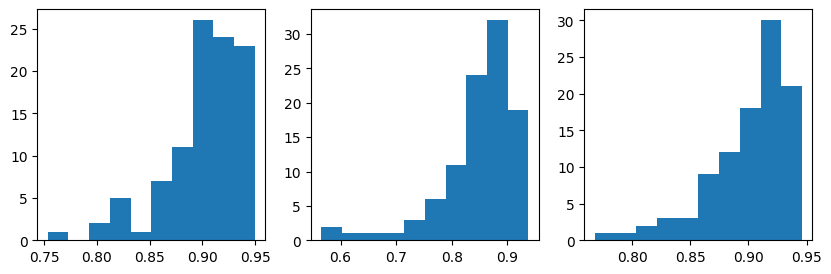

In [17]:
# Create the histograms of dice scores
fig, axs = plt.subplots(1,3, figsize=(10,3))
axs[0].hist(scores_2d.mean(axis=1))
axs[1].hist(scores_3d.mean(axis=1))
axs[2].hist(scores_combo.mean(axis=1))
plt.savefig("figures/histograms",bbox_inches="tight")
plt.show()

## Generate images of the best and worst sample

In [18]:
best = scores_combo.mean(axis=1).argmax()
worst = scores_combo.mean(axis=1).argmin()

In [19]:
best_sample = test_set[best]
with torch.no_grad():
    output_3d = softmax(inferer_3d(best_sample['img'].unsqueeze(0).to(device), model_3d))
    output_2d = softmax(inferer_2d(best_sample['img'].unsqueeze(0).to(device), model_2d))
output_combo = (output_3d * 0.5 + output_2d * 0.5)

classification_3d = [output_transform(x).cpu() for x in output_3d]
classification_2d = [output_transform(x).cpu() for x in output_2d]
classification_combo = [output_transform(x).cpu() for x in output_combo]

# Convert to SITK image for resampling
image_3d = sitk.GetImageFromArray(classification_3d[0].squeeze())
image_2d = sitk.GetImageFromArray(classification_2d[0].squeeze())
image_combo = sitk.GetImageFromArray(classification_combo[0].squeeze())

# Set the SITK spacing to the current spacing
cur_spacing = (float(sample['img_spacing'][0]), float(sample['img_spacing'][1]), float(sample['img_spacing'][2]))
image_3d.SetSpacing(cur_spacing)
image_2d.SetSpacing(cur_spacing)
image_combo.SetSpacing(cur_spacing)

# Resample back to the original spacing
resampled_3d = resample_img(image_3d, [float(x) for x in sample['org_spacing']], True)
resampled_2d = resample_img(image_2d, [float(x) for x in sample['org_spacing']], True)
resampled_combo = resample_img(image_combo, [float(x) for x in sample['org_spacing']], True)

# Read image data from SITK image
best_3d = sitk.GetArrayFromImage(resampled_3d)
best_2d = sitk.GetArrayFromImage(resampled_2d)
best_combo = sitk.GetArrayFromImage(resampled_combo)

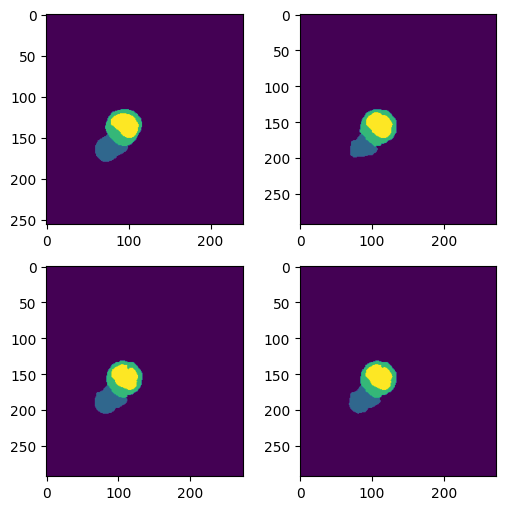

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
slice_num = best_3d.shape[0]//2
axs[0, 0].imshow(best_sample['mask'][0, slice_num])
axs[0, 1].imshow(best_3d[slice_num])
axs[1, 0].imshow(best_2d[slice_num])
axs[1, 1].imshow(best_combo[slice_num])
plt.savefig("figures/best_middle", bbox_inches="tight")
plt.show()

In [21]:
worst_sample = test_set[worst]
with torch.no_grad():
    output_3d = softmax(inferer_3d(worst_sample['img'].unsqueeze(0).to(device), model_3d))
    output_2d = softmax(inferer_2d(worst_sample['img'].unsqueeze(0).to(device), model_2d))
output_combo = (output_3d * 0.5 + output_2d * 0.5)

classification_3d = [output_transform(x).cpu() for x in output_3d]
classification_2d = [output_transform(x).cpu() for x in output_2d]
classification_combo = [output_transform(x).cpu() for x in output_combo]

# Convert to SITK image for resampling
image_3d = sitk.GetImageFromArray(classification_3d[0].squeeze())
image_2d = sitk.GetImageFromArray(classification_2d[0].squeeze())
image_combo = sitk.GetImageFromArray(classification_combo[0].squeeze())

# Set the SITK spacing to the current spacing
cur_spacing = (float(sample['img_spacing'][0]), float(sample['img_spacing'][1]), float(sample['img_spacing'][2]))
image_3d.SetSpacing(cur_spacing)
image_2d.SetSpacing(cur_spacing)
image_combo.SetSpacing(cur_spacing)

# Resample back to the original spacing
resampled_3d = resample_img(image_3d, [float(x) for x in sample['org_spacing']], True)
resampled_2d = resample_img(image_2d, [float(x) for x in sample['org_spacing']], True)
resampled_combo = resample_img(image_combo, [float(x) for x in sample['org_spacing']], True)

# Read image data from SITK image
worst_3d = sitk.GetArrayFromImage(resampled_3d)
worst_2d = sitk.GetArrayFromImage(resampled_2d)
worst_combo = sitk.GetArrayFromImage(resampled_combo)

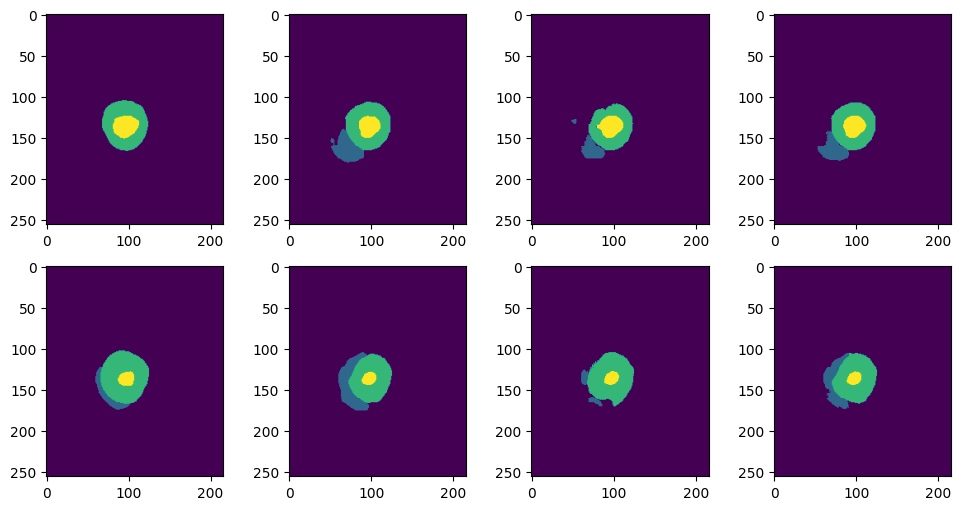

In [22]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
slice_num = 1
axs[0, 0].imshow(worst_sample['mask'][0, slice_num])
axs[0, 1].imshow(worst_2d[slice_num])
axs[0, 2].imshow(worst_3d[slice_num])
axs[0, 3].imshow(worst_combo[slice_num])
slice_num = worst_3d.shape[0]//2
axs[1, 0].imshow(worst_sample['mask'][0, slice_num])
axs[1, 1].imshow(worst_2d[slice_num])
axs[1, 2].imshow(worst_3d[slice_num])
axs[1, 3].imshow(worst_combo[slice_num])
plt.savefig("figures/worsts", bbox_inches="tight")
plt.show()